In [24]:
from ase.build import mx2
from gpaw import GPAW, PW, FermiDirac

structure = mx2(formula='MoS2', kind='2H', a=3.184, thickness=3.127,size=(1, 1, 1), vacuum=3.5)
structure.pbc = (1, 1, 0)

calc = GPAW(mode=PW(200),xc='PBE',setups={'Mo': '6'}, parallel={'kpt': 1},kpts={'size': (2,2,1), 'gamma': True},occupations=FermiDirac(0.01))

structure.set_calculator(calc)
structure.get_potential_energy()
calc.write('MoS2_gs.gpw', 'all')



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  1.3.0
 |___|_|             

User:   Yaroslav@MacBook-Pro-Aroslav-2.local
Date:   Wed Mar 28 23:12:03 2018
Arch:   x86_64
Pid:    664
Python: 2.7.14
gpaw:   /Users/Yaroslav/Library/Python/2.7/lib/python/site-packages/gpaw
_gpaw:  /Users/Yaroslav/Library/Python/2.7/lib/python/site-packages/_gpaw.so
ase:    /usr/local/lib/python2.7/site-packages/ase (version 3.15.0)
numpy:  /Users/Yaroslav/Library/Python/2.7/lib/python/site-packages/numpy (version 1.13.3)
scipy:  /usr/local/lib/python2.7/site-packages/scipy (version 0.19.1)
units:  Angstrom and eV
cores:  1

Input parameters:
  kpts: {gamma: True,
         size: (2, 2, 1)}
  mode: {ecut: 200.0,
         name: pw}
  occupations: {name: fermi-dirac,
                width: 0.01}
  setups: {Mo: 6}
  xc: PBE

Timing:                              incl.     excl.
-----------------------------------------------------------
Hamiltonian:                       

In [25]:
calc.diagonalize_full_hamiltonian()
calc.write('gs_MoS2.gpw', mode='all')

Diagonalizing full Hamiltonian (578 lowest bands)
Matrix size (min, max): 578, 587
Approximate memory used per core to store H_GG, S_GG: 15.773 MB
Notice: Up to twice the amount of memory might be allocated
during diagonalization algorithm.
The least memory is required when the parallelization is purely
over states (bands) and not k-points, set GPAW(..., parallel={'kpt': 1}, ...).
2.50947189331s |----------------------------------------| Time: 2.396s
Writing to gs_MoS2.gpw (mode='all')



In [26]:
from gpaw.response.g0w0 import G0W0
gw = G0W0(calc='gs_MoS2.gpw',
              bands=(8, 11),
              ecut=50,
              truncation='2D',
              nblocksmax=True,
              anisotropy_correction=True,
              filename='MoS2_g0w0',
              savepckl=True)
result=gw.calculate()

In [27]:
from gpaw.response import bse 

ecut = 50
eshift = 0.8

bse = bse.BSE('gs_MoS2.gpw',
          ecut=ecut,
          valence_bands=[8],
          conduction_bands=[9,10],
          truncation='2D',
          nbands=50,
          eshift=eshift,
          mode='BSE',
          integrate_gamma=1,
          txt='bse_MoS2_trun.txt')

In [28]:
import numpy as np
result=bse.get_polarizability(filename='pol_bse_MoS2_trun.csv',
                       eta=0.01,
                       pbc=[True, True, False],
                       write_eig='bse_MoS2_eig_trun.dat',
                       w_w=np.linspace(0, 5, 51))

In [29]:
nK=bse.kd.nbzkpts
nv=1;nc=2
H_bse=bse.H_sS.reshape((nK,nv,nc,nK,nv,nc))

In [30]:
from gpaw.kpt_descriptor import KPointDescriptor
from gpaw.wavefunctions.pw import PWDescriptor
from gpaw.response.kernels import get_coulomb_kernel
from gpaw.response.kernels import get_integrated_kernel
from gpaw.response.wstc import WignerSeitzTruncatedCoulomb
from gpaw.response.pair import PairDensity


In [31]:
bse.q_c=[0.0, 0.0, 0.0]
bse.wstc=None
qd0 = KPointDescriptor([bse.q_c])
pd0 = PWDescriptor(bse.ecut, bse.calc.wfs.gd, complex, qd0)
ikq_k = bse.kd.find_k_plus_q(bse.q_c)
v_G = get_coulomb_kernel(pd0, bse.kd.N_c, truncation=bse.truncation, wstc=None)
bse.pair = PairDensity(bse.calc, bse.ecut)
bse.Q_qaGii = [];bse.W_qGG = [];bse.pd_q = []
bse.get_screened_potential(ac=1.0)

Shifting Fermi-level by 0.00 eV
Number of completely filled bands: 9
Number of partially filled bands: 9
Total number of bands: 578
Number of blocks: 1


In [32]:
kpoints=bse.kd.bzk_kc
conduction_bands=[9,10]

In [33]:
from itertools import product
import progressbar
H_trion=np.zeros((nK,nK,nv,nc,nc,
                  nK,nK,nv,nc,nc),dtype=np.complex)
bar=progressbar.ProgressBar()
for k in range(nK):
    for c in range(nc):
        H_trion[k,:,:,c,:,k,:,:,c,:]+=H_bse
        H_trion[:,k,:,:,c,:,k,:,:,c]+=H_bse
H_trion_free=np.copy(H_trion)
first_kpoints=[(k1,k1_) for k1,k1_ in product(range(nK),range(nK))]

for i in bar(range(len(first_kpoints))):
    k1,k1_=first_kpoints[i]
    for k2,k2_ in product(range(nK),range(nK)):
        kp1=kpoints[k1]-kpoints[k1_];
        kp2=kpoints[k2]-kpoints[k2_];
        if (kp1==kp2).all():
            for c1,c2 in product(range(nc),range(nc)):
                kpt1_1 = bse.pair.get_k_point(0, k1, conduction_bands[c1], conduction_bands[c1]+1)
                kpt2_1 = bse.pair.get_k_point(0, k1_, conduction_bands[c2], conduction_bands[c2]+1)

                kpt1_2 = bse.pair.get_k_point(0, k2, conduction_bands[c1], conduction_bands[c1]+1)
                kpt2_2 = bse.pair.get_k_point(0, k2_, conduction_bands[c2], conduction_bands[c2]+1)

                rho1, iq1 = bse.get_density_matrix(kpt1_1,kpt2_1)
                rho2, iq2 = bse.get_density_matrix(kpt1_2,kpt2_2)

                rho3, iq3 = bse.get_density_matrix(kpt2_1,kpt1_1)
                rho4, iq4 = bse.get_density_matrix(kpt2_2,kpt1_2)
                W1 = np.swapaxes(np.dot(np.dot(rho1.conj(),bse.W_qGG[iq1]),np.swapaxes(rho2, 1, 2)), 1, 2)
                W2 = np.swapaxes(np.dot(np.dot(rho3.conj(),bse.W_qGG[iq3]),np.swapaxes(rho4, 1, 2)), 1, 2)

                H_trion[k1,k1_,:,c1,c2,k2,k2_,:,c1,c2]+=(W1-W2).reshape(1)[0]

100% |########################################################################|


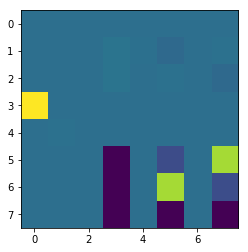

In [52]:
plt.imshow(bse.H_sS.real)

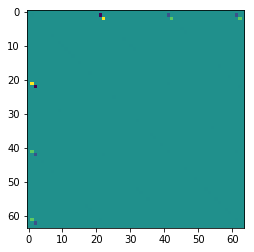

In [57]:
plt.imshow((H_trion-H_trion_free).imag)

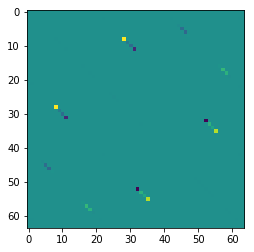

In [58]:
plt.imshow((H_trion-H_trion_free).real)

In [54]:
nS=nK*nK*nv*nc*nc
H_trion=H_trion.reshape((nS,nS))
H_trion_free=H_trion_free.reshape((nS,nS))
E_trion,D_trion=np.linalg.eigh(H_trion)
E_trion_free,D_trion_free=np.linalg.eigh(H_trion_free)
E_bse,D_bse=np.linalg.eigh(bse.H_sS)

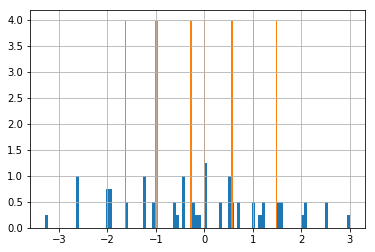

In [51]:
plt.hist(E_trion,normed=True,bins=100)
plt.hist(E_bse,normed=True,bins=100)
plt.grid()